# 20190821 operator-barcode library mapping

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [152]:
import os
import glob
import itertools
import re
import numpy as np
import pandas as pd
import skbio

# Import this project's library
import rnaseq_barcode as rnaseq

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib_venn as mpl_venn

# Seaborn, useful for graphics
import seaborn as sns

# Import Interactive plot libraries
import bokeh.plotting
import bokeh.layouts
from bokeh.themes import Theme
import holoviews as hv
import hvplot
import hvplot.pandas
import panel as pn
import bokeh_catplot

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

In [150]:
# Set PBoC style for plot
rnaseq.viz.pboc_style_mpl()

# Increase dpi
mpl.rcParams['figure.dpi'] = 110

theme = Theme(json=rnaseq.viz.pboc_style_bokeh())
hv.renderer('bokeh').theme = theme
bokeh.io.curdoc().theme = theme

## Objective

The objective of this notebook is to process the sequences generated on `20190818` to map the `O1`, `O2`, and `O3` libraries with their corresponding random 20mer barcodes.

For this dataset we have two technical replicas given by two different barcodes. In principle these libraries should be exactly the same since they were generated from the same library and only on the last PCRs the different index were added. Let's first find these files.

In [18]:
# Define data directory
datadir = '../../../data/processed_sequencing/' +\
          '20190821_operator_library_mapping/'

# List all fastq.gz files
fastq_files = glob.glob(f'{datadir}*.fastq.gz')

fastq_files

['../../../data/processed_sequencing/20190821_operator_library_mapping/index1_merged.fastq.gz',
 '../../../data/processed_sequencing/20190821_operator_library_mapping/index2_merged.fastq.gz']

Ok. We now have a list of the files, now we can begin manipulating them. To get a feeling for the data let's partially read one of them into memory.

In [45]:
# Use skbio to have a generator to iterate over fastq
seqs = skbio.io.read(datadir + fastq_files[0],
                     format='fastq',
                     verify='false',
                     variant='illumina1.8')

# Define number of samples
n_samples = 10000

# Initialize dataframe to save sequences
names = ['id', 'index', 'sequence']
df_seq = pd.DataFrame(columns=names)

# Iterate over sequences
for seq in itertools.islice(seqs, n_samples):
    # Add DNA sample to corresponding list
    df_seq = df_seq.append({'id': seq.metadata['id'],
                            'index' : 'index1',
                            'sequence' : str(skbio.DNA(sequence=seq, 
                                                       validate=False))},
                           ignore_index=True)

df_seq['seq_len'] =  df_seq.sequence.apply(len)
df_seq.head()

,id,index,sequence,seq_len
0,M05340:171:000000000-D6YGV:1:1101:16708:1702,index1,TCTTGACCATTTAGGTTTGGGCATGTGAGACCGGATGCTAACTAAA...,113
1,M05340:171:000000000-D6YGV:1:1101:16708:1702,index1,TTTACACTTTATTCTTCCTGCTCGTCTCCTTTTTTGAAATGTGATC...,113
2,M05340:171:000000000-D6YGV:1:1101:13854:1711,index1,TTATCATGGGTTGTTAAGAGGCATGTGAGACCGGATGCTAACTAAA...,113
3,M05340:171:000000000-D6YGV:1:1101:13854:1711,index1,TTTACACTTTCTGCTTCCTGCTCGTATCCTTTTTTTAATTGTGCTC...,113
4,M05340:171:000000000-D6YGV:1:1101:15932:1711,index1,TACCTGAAGGCTATTTCCCTGCATGTGAGACCGGATGCTAACTAAA...,113


Now let's define the 3 sequences for the operators. We will reverse complement them since the reads start from the barcode and then go through the reverse complement of the operators.

In [46]:
O1 = skbio.DNA('aattgtgagcggataacaatt'.upper()).reverse_complement()
O2 = skbio.DNA('aaatgtgagcgagtaacaacc'.upper()).reverse_complement()
O3 = skbio.DNA('ggcagtgagcgcaacgcaatt'.upper()).reverse_complement()
operators = {'O1': str(O1),
             'O2': str(O2),
             'O3': str(O3)}
operators

{'O1': 'AATTGTTATCCGCTCACAATT',
 'O2': 'GGTTGTTACTCGCTCACATTT',
 'O3': 'AATTGCGTTGCGCTCACTGCC'}

Now we define a function to find which operator is found in each of the sequences and apply it to all sequences.

In [47]:
# Define function to find operator
def op_match(seq):
    '''
    Function to match the operator sequences
    '''
    # Loop through operators
    for key, item in operators.items():
        # Find operator and return boolean if found
        op_pos = re.search(item, seq)
        # If found return the operator and break loop
        if bool(op_pos):
            return [key] + [*op_pos.span()]
            break

    # If none match, return none
    if not bool(op_pos):
        return ['None', 0, 0]
    
op_map = list()
# Loop through rows
for seq in df_seq.sequence:
     op_map.append(op_match(seq))

df_seq = pd.concat([df_seq,
                    pd.DataFrame.from_records(op_map,
                                              columns=['operator',
                                                       'op_begin',
                                                       'op_end'])],
                   axis=1)
df_seq.head(10)

,id,index,sequence,seq_len,operator,op_begin,op_end
0,M05340:171:000000000-D6YGV:1:1101:16708:1702,index1,TCTTGACCATTTAGGTTTGGGCATGTGAGACCGGATGCTAACTAAA...,113,O2,56,77
1,M05340:171:000000000-D6YGV:1:1101:16708:1702,index1,TTTACACTTTATTCTTCCTGCTCGTCTCCTTTTTTGAAATGTGATC...,113,None,0,0
2,M05340:171:000000000-D6YGV:1:1101:13854:1711,index1,TTATCATGGGTTGTTAAGAGGCATGTGAGACCGGATGCTAACTAAA...,113,O2,56,77
3,M05340:171:000000000-D6YGV:1:1101:13854:1711,index1,TTTACACTTTCTGCTTCCTGCTCGTATCCTTTTTTTAATTGTGCTC...,113,None,0,0
4,M05340:171:000000000-D6YGV:1:1101:15932:1711,index1,TACCTGAAGGCTATTTCCCTGCATGTGAGACCGGATGCTAACTAAA...,113,O1,56,77
5,M05340:171:000000000-D6YGV:1:1101:15932:1711,index1,TTTCCACTTTCTTCTTCCTTCTCGTCTCCTTTTTTTATTTTTGCTC...,113,None,0,0
6,M05340:171:000000000-D6YGV:1:1101:16589:1721,index1,TATGCTGTACTGGGTTATTCGCATGTGAGACCGGTTGCTAACTAAC...,113,None,0,0
7,M05340:171:000000000-D6YGV:1:1101:16589:1721,index1,TTTCCCCTTTCTTCTTCCTTCTCTTCTCCTTTTTTTCTTTTTTCTC...,113,None,0,0
8,M05340:171:000000000-D6YGV:1:1101:14894:1735,index1,TTCTTCTGTGTATTAGACTTGCATGTGAGACCGGATGCTAACTAAA...,113,O1,56,77
9,M05340:171:000000000-D6YGV:1:1101:14894:1735,index1,TTTCCACTTTATTCTTCCTTCTCGTCTCCTTTTTTTAATTGTGCTC...,113,None,0,0


Let's look at a summary table of each operator count.

In [48]:
df_seq.operator.value_counts()

O3      3045
O2      2787
O1      2659
None    1509
Name: operator, dtype: int64

There are a lot of `None` entries which means that the algorithm didn't find any of the operators. We'll come back to those later.

First thing, let's count how many unique sequences we have for each operator. We will be very stringent with our filtering of the barcodes. We know that the operator should be located exactly at position 56 of the sequences. So we will only keep the ones that satisfy this condition.

In [59]:
# Remove sequences that didn't map to an operator.
df = df_seq[(df_seq.operator != 'None') &  # Remove sequences that din't map
            (df_seq.seq_len == 113) &  # Keep sequences with expected length
            (df_seq.op_begin == 56)]  # Keep sequences with expected position

# Count unique sequences
df.groupby('operator')['sequence'].nunique()

operator
O1    1500
O2    1275
O3    1044
Name: sequence, dtype: int64

So about half of the sequences are unique. Let's now build a table with the sequences that passed the filter with the number of counts for each of them. We will also extract the first 20 bp of the sequence that we know must correspond to the barcode.

In [76]:
# Group by operator
df_group = df.groupby('operator')

# Initialize dataframe to save outcome
names = ['operator', 'sequence', 'barcode', 'counts']
df_counts = pd.DataFrame(columns=names)

# Loop thorough operators
for group, data in df_group:
    # Count unique barcodes and turn it into a DataFrame
    df_op = data['sequence'].value_counts()\
                            .rename_axis('sequence')\
                            .reset_index(name='counts')
    # Add a column that contains operator
    df_op['operator'] = [group] * len(df_op)
    # Extract barcodes
    df_op['barcode'] = df_op['sequence'].apply(lambda x: x[0:20])
    # Append to dataframe
    df_counts = df_counts.append(df_op,
                                 ignore_index=True,
                                 sort=False)

df_counts.head()

,operator,sequence,barcode,counts
0,O1,GCAGTAGTATCTTGTGCTGTGCATGTGAGACCGGATGCTAACTAAA...,GCAGTAGTATCTTGTGCTGT,8
1,O1,CGGAGTTCGTTGCTGGGAGCGCATGTGAGACCGGATGCTAACTAAA...,CGGAGTTCGTTGCTGGGAGC,7
2,O1,TAGCCTCTTCTTTACGATTGGCATGTGAGACCGGATGCTAACTAAA...,TAGCCTCTTCTTTACGATTG,6
3,O1,CCTTTCTTGGCACTCACCATGCATGTGAGACCGGATGCTAACTAAA...,CCTTTCTTGGCACTCACCAT,6
4,O1,CCACCGTTGACGTCGGCTCTGCATGTGAGACCGGATGCTAACTAAA...,CCACCGTTGACGTCGGCTCT,6


Excellent! Now we have a working pipeline to process the sequences. The analysis for the full dataset is performed with the script `library_mapping.py`.

## Analysis of the entire library

Let's take a look at the results for the entire library. First we import the summary table with the unique set of barcodes.

In [118]:
# Define output directory
outdir = '../../../data/barcodes/' +\
         '20190821_operator_library_mapping/'

# List files with summary table
files = glob.glob(f'{outdir}*counts.csv')

df_barcodes = pd.DataFrame()
# Loop through files, read into memory, add index column and append
for f in files:
    # Extract index name from file name
    index = f.split('/')[-1].split('_')[0]
    # Read file into memory
    df = pd.read_csv(f)
    # Add file index
    df['idx'] = [index] * len(df)
    # Append to dataframe
    df_barcodes = pd.concat([df_barcodes, df],
                                     ignore_index=True)
    

df_barcodes.head()

,operator,sequence,barcode,counts,idx
0,O1,CCACCGTTGACGTCGGCTCTGCATGTGAGACCGGATGCTAACTAAA...,CCACCGTTGACGTCGGCTCT,286,index2
1,O1,TCCCTTGCACCATATGGTTTGCATGTGAGACCGGATGCTAACTAAA...,TCCCTTGCACCATATGGTTT,284,index2
2,O1,TGATGTGCTTCTTGAGACAAGCATGTGAGACCGGATGCTAACTAAA...,TGATGTGCTTCTTGAGACAA,267,index2
3,O1,TTTAATTATTAAACGGCGCTGCATGTGAGACCGGATGCTAACTAAA...,TTTAATTATTAAACGGCGCT,267,index2
4,O1,TAGTTTTATCCAGGGACACGGCATGTGAGACCGGATGCTAACTAAA...,TAGTTTTATCCAGGGACACG,266,index2


Let's look at the distribution of barcode count number for each of the technical replicas.

In [148]:
p = bokeh_catplot.ecdf(
    data=df_barcodes,
    cats='operator',
    val='counts',
    formal=True,
)

bokeh.io.show(p)

There is a big chunck of barcodes that appear a single time.
Guillaume's threshold takes into account only barcodes that were found at least 3 times. So let's see what fraction of those satisfy the criteria

In [143]:
# group by operator
df_group = df_barcodes.groupby('operator')

print('Global number of unique operators >= 3 counts:')
print(f'''
{np.sum(df_barcodes.counts >= 3)} out of {len(df_barcodes)}
{np.round(np.sum(df_barcodes.counts > 3) / len(df_barcodes) * 100, 2)}%
'''
)
# Loop through operators
for group, data in df_group:
    print(f'{group} number of unique operators >= 3 counts:')
    print(f'''
    {np.sum(data.counts >= 3)} out of {len(data)}
    {np.round(np.sum(data.counts >= 3) / len(data) * 100, 2)}%
    '''
    )
    

Global number of unique operators >= 3 counts:

9906 out of 46488
21.1%

O1 number of unique operators >= 3 counts:

    4533 out of 16483
    27.5%
    
O2 number of unique operators >= 3 counts:

    3142 out of 14526
    21.63%
    
O3 number of unique operators >= 3 counts:

    2231 out of 15479
    14.41%
    


And the ECDF for these barcodes that pass the $\geq$ 3 threshold looks like

In [147]:
p = bokeh_catplot.ecdf(
    data=df_barcodes[df_barcodes.counts >= 3],
    cats='operator',
    val='counts',
    formal=True,
)

bokeh.io.show(p)

So O3 is biased towards more counts per unique barcode, followed by O2 and the most diverse operator is O1.

### Overlapping barcodes between the three operators

Let's find out how many barcodes are shared between the three operators. For this we will generate a Venn diagram.

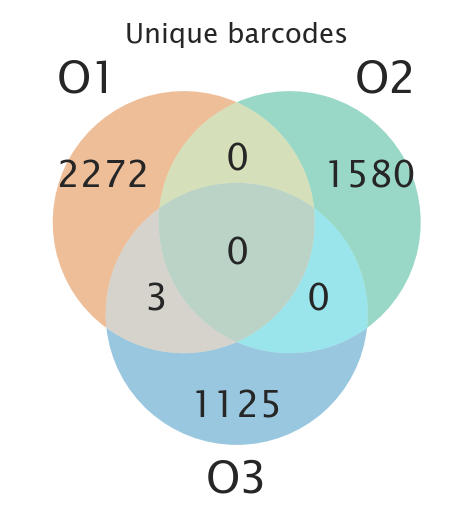

In [162]:
# Group by operator filtering for unique barcodes
df_group = df_barcodes[df_barcodes.counts >= 3].groupby('operator')
# Generate list of sets for barcodes
op_list = list()
set_list = list()

# Loop through operators
for group, data in df_group:
    op_list.append(group)
    set_list.append(set(data.barcode.values))
    
# generate plot
fig, ax = plt.subplots(1, 1)
mpl_venn.venn3_unweighted(set_list, set_labels=op_list,
                          ax=ax)
_ = ax.set_title('Unique barcodes')

The Venn diagram shows that there are basically only three barcodes shared beetween O1 and O3. But the problem is that the numbers in this diagram do not actually reflect the numbers that we got from the previous analysis. It seems that there are almost half the number of unique barcodes on each of these operators compared to our previous calculation. Let's troubleshoot that.

## Verifying constant regionsonly the barcode**. So it could be the case that what we classified as unique sequences had mutations somewhere else along the sequence and were counted as individual sequences.

To check for this mistake we will verify that the RNAP binding site region, and the cloning site between the operator and the barcode are what we expect them to be. This will apply another strong filter on which sequences we actually consider for our analysis.

First let's read the entire list of sequences with mapped barcodes into memory

One of the reasons why the numbers differ between our account for unique sequences and the Venn diagram is that the former was done on the **unique sequences in the list**, meaning all of the sequence including operator, promoter and barcode, while the Venn diagram was done using **only the barcode**. So it could be the case that what we classified as unique sequences had mutations somewhere else along the sequence and were counted as individual sequences.

To check for this mistake we will verify that the RNAP binding site region, and the cloning site between the operator and the barcode are what we expect them to be. This will apply another strong filter on which sequences we actually consider for our analysis.

First let's read the entire list of sequences with mapped barcodes into memory

In [171]:
# Define output directory
outdir = '../../../data/barcodes/' +\
         '20190821_operator_library_mapping/'

# List files with summary table
files = glob.glob(f'{outdir}*raw*.csv')

df_seq = pd.DataFrame()
# Loop through files, read into memory, add index column and append
for f in files:
    # Extract index name from file name
    index = f.split('/')[-1].split('_')[0]
    # Append to dataframe
    df_seq = pd.concat([df_seq, pd.read_csv(f)],
                       ignore_index=True)
    
# Remove the none sequences
df_seq = df_seq[df_seq.operator != 'None']

df_seq.head()

,id,index,sequence,seq_len,operator,op_begin,op_end
14,M05340:171:000000000-D6YGV:1:1101:13953:1670,index1,TGGATCGTGTTCCATCTCTCGCATGTGAGACCGGATGCTAACTAAA...,113,O3,56,77
16,M05340:171:000000000-D6YGV:1:1101:18659:1670,index1,TTTTGCAGTAGATCTACACTGCATGTGAGACCGGATGCTAACTAAA...,113,O3,56,77
20,M05340:171:000000000-D6YGV:1:1101:16487:1677,index1,TAATAGTATGCTTTAATTTTGCATGTGAGACCGGATGCTAACTAAA...,113,O1,56,77
28,M05340:171:000000000-D6YGV:1:1101:14158:1684,index1,TTTCTTGTTTATCATGTAGTGCATGTGAGACCGGATGCTAACTAAA...,113,O1,56,77
30,M05340:171:000000000-D6YGV:1:1101:17538:1692,index1,TTTTTCACCAACTGGGTTTTGCATGTGAGACCGGATGCTAACTAAA...,113,O2,56,77


Now let's define the RNAP binding site and the cloning site sequences as designed in our cloning scheme. We will map these sequences for each of the elements in the DataFrame using a similar function as before.

In [170]:
# Define RNAP binding site
rnap = str(skbio.DNA('TTTACACTTTATGCTTCCGGCTCGTATAATGTGTGG').\
           reverse_complement())
# Define sequence post operator
cloning = str(skbio.DNA('GCTAGCGGTGTTTAGTTAGCATCCGGTCTCACATGC').\
          reverse_complement())

def const_match(seq):
    '''
    Function to match the operator sequences
    '''
    # Find RNAP
    rnap_pos = re.search(rnap, seq)
    # Find cloning site
    cloning_pos = re.search(cloning, seq)
    
    # Determine if RNAP was found
    if bool(rnap_pos):
        RNAP = [True] + [*rnap_pos.span()]
    else:
        RNAP = [False, 0, 0]
    # Determine if cloning site was found
    if bool(cloning_pos):
        CLONING = [True] + [*cloning_pos.span()]
    else:
        CLONING = [False, 0, 0]
    
    return RNAP + CLONING

# Initialize list to save results
const_map = list()
# Loop through rows
for seq in df_seq.sequence:
     const_map.append(const_match(seq))

df_seq = pd.concat([df_seq,
                    pd.DataFrame.from_records(const_map,
                                              columns=['rnap',
                                                       'rnap_begin',
                                                       'rnap_end',
                                                       'cloning',
                                                       'cloning_begin',
                                                       'cloning_end'])],
                   axis=1, ignore_index=True)
df_seq.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0,True,20.0,56.0


In [167]:
const_map[0]

[False, 0, 0, True, 20, 56]